### Analiza Attention po uczeniu (dla epizodów ewaluacyjnych)

In [1]:
# eval_attention_stats.py
import os
import time
from typing import Optional, Sequence, Dict, Any, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
import torch as th

# ---------- tiny helpers (gym/gymnasium compatible) ----------
def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _to_1d_bool(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.ndim == 0:
        return np.array([bool(x)], dtype=bool)
    if x.ndim > 1:
        x = x.reshape(-1)
    return x

# ---------- core evaluation + stats ----------
@th.no_grad()
def evaluate_attention_stats(
    env,
    model,
    n_episodes: int = 10,
    deterministic: bool = True,
    freeze_vecnorm: bool = True,
    FEATURE_NAMES: Optional[Sequence[str]] = None,
    eps: float = 1e-8,                # threshold for "freq"
    top_k: int = 30,
    save_dir: Optional[str] = None,   # if None: no files saved
    save_prefix: str = "attn_eval",
    make_plots: bool = True,
) -> Dict[str, Any]:
    """
    Run evaluation episodes and compute the same statistics as your training attention callback.

    Returns a dict with:
      - 'metric_mean', 'metric_var', 'metric_freq'   : [N]
      - 'contrib_mean', 'contrib_var', 'contrib_freq': [N]
      - 'A_mean'                                     : [N, N] (mean attention matrix)
      - 'feature_names'                              : [N]
      - 'episodes', 'steps_total', 'ep_returns'      : metadata
      - plus 'tables' with sorted (top_k) DataFrames if pandas is available
    """
    # keep VecNormalize reward semantics = true env reward
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("Use a single-env VecEnv for eval.")

    fe = getattr(model.policy, "features_extractor", None)
    if fe is None or not hasattr(fe, "metric_importance"):
        raise AttributeError("Policy features_extractor missing 'metric_importance' / 'contrib_importance'.")

    # Infer N and feature names
    N = getattr(fe, "n_metrics", None) or getattr(fe, "final_out_dim", None)
    if N is None:
        # last-resort from space
        N = int(getattr(env, "observation_space").shape[-1])
    if FEATURE_NAMES is None or len(FEATURE_NAMES) != N:
        feature_names = np.array([f"f{i}" for i in range(N)], dtype=str)
    else:
        feature_names = np.array(list(FEATURE_NAMES), dtype=str)

    metric_list: List[np.ndarray] = []
    contrib_list: List[np.ndarray] = []
    A_sum = None
    A_count = 0
    ep_returns: List[float] = []

    state = None
    steps_total = 0

    for _ in range(n_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):  # gymnasium (obs, info)
            obs = obs[0]

        episode_start = np.array([True], dtype=bool) if is_vec else None
        done = False
        ret = 0.0

        while not done:
            # Predict action (RecurrentPPO-aware)
            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(
                    obs, state=state, deterministic=deterministic
                )

            # --- read attention diagnostics for *current* obs ---
            mi = getattr(fe, "metric_importance", None)
            if mi is not None:
                mi_np = mi.detach().cpu().numpy()
                if mi_np.ndim == 2:
                    metric_list.append(mi_np[0].copy() if mi_np.shape[0] == 1 else mi_np.mean(axis=0).copy())
                elif mi_np.ndim == 1:
                    metric_list.append(mi_np.copy())

            ci = getattr(fe, "contrib_importance", None)
            if ci is not None:
                ci_np = ci.detach().cpu().numpy()
                if ci_np.ndim == 2:
                    contrib_list.append(ci_np[0].copy() if ci_np.shape[0] == 1 else ci_np.mean(axis=0).copy())
                elif ci_np.ndim == 1:
                    contrib_list.append(ci_np.copy())

            A = getattr(fe, "attn_matrix", None)
            if A is not None:
                A_np = A.detach().cpu().numpy()
                if A_np.ndim == 3:
                    A_np = A_np[0]
                if A_sum is None:
                    A_sum = A_np.astype(np.float64)
                else:
                    A_sum += A_np
                A_count += 1

            # Step env
            if is_vec:
                obs, r, d, info = env.step(action)
                r_scalar = _scalar(r)
                done_scalar = _done_scalar(d)
                episode_start = _to_1d_bool(d)
            else:
                step_out = env.step(action)
                if len(step_out) == 5:
                    obs, r, terminated, truncated, info = step_out
                    done_scalar = bool(terminated or truncated)
                else:
                    obs, r, done_scalar, info = step_out
                r_scalar = float(np.asarray(r).squeeze())

            ret += r_scalar
            done = done_scalar
            steps_total += 1

        ep_returns.append(ret)
        state = None  # reset hidden state

    # --- stack and compute stats ---
    if len(metric_list) == 0:
        metric_arr = np.zeros((1, N), dtype=np.float32)
    else:
        metric_arr = np.stack(metric_list, axis=0).astype(np.float32)  # [T, N]

    if len(contrib_list) == 0:
        contrib_arr = np.zeros((1, N), dtype=np.float32)
    else:
        contrib_arr = np.stack(contrib_list, axis=0).astype(np.float32)  # [T, N]

    metric_mean = metric_arr.mean(axis=0)
    metric_var  = metric_arr.var(axis=0, ddof=1) if metric_arr.shape[0] > 1 else np.zeros(N, dtype=np.float32)
    metric_freq = (metric_arr > eps).mean(axis=0)

    contrib_mean = contrib_arr.mean(axis=0)
    contrib_var  = contrib_arr.var(axis=0, ddof=1) if contrib_arr.shape[0] > 1 else np.zeros(N, dtype=np.float32)
    contrib_freq = (contrib_arr > eps).mean(axis=0)

    A_mean = (A_sum / max(1, A_count)).astype(np.float32) if A_sum is not None else None

    # --- build sorted top-k tables (optional) ---
    try:
        import pandas as pd
        df_metric = pd.DataFrame({
            "feature": feature_names, "idx": np.arange(N),
            "mean": metric_mean, "var": metric_var, "freq": metric_freq
        }).sort_values("mean", ascending=False).reset_index(drop=True)
        df_contrib = pd.DataFrame({
            "feature": feature_names, "idx": np.arange(N),
            "mean": contrib_mean, "var": contrib_var, "freq": contrib_freq
        }).sort_values("mean", ascending=False).reset_index(drop=True)
        tables = {
            "metric_topk": df_metric.head(min(top_k, N)),
            "contrib_topk": df_contrib.head(min(top_k, N)),
            "metric_all": df_metric,
            "contrib_all": df_contrib,
        }
    except Exception:
        tables = {}

    # --- save to disk (NPZ + CSVs) ---
    saved: Dict[str, str] = {}
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        ts = time.strftime("%Y%m%d_%H%M%S")
        base = f"{save_prefix}_{ts}"

        npz_path = os.path.join(save_dir, f"{base}.npz")
        np.savez_compressed(
            npz_path,
            metric_mean=metric_mean, metric_var=metric_var, metric_freq=metric_freq,
            contrib_mean=contrib_mean, contrib_var=contrib_var, contrib_freq=contrib_freq,
            A_mean=A_mean if A_mean is not None else np.array([], dtype=np.float32),
            feature_names=np.asarray(feature_names),
            episodes=np.int32(n_episodes),
            steps_total=np.int32(steps_total),
            ep_returns=np.asarray(ep_returns, dtype=np.float32),
        )
        saved["summary_npz"] = npz_path

        # optional CSVs for human reading
        if tables:
            try:
                tables["metric_all"].to_csv(os.path.join(save_dir, f"{base}_metric_all.csv"), index=False)
                tables["contrib_all"].to_csv(os.path.join(save_dir, f"{base}_contrib_all.csv"), index=False)
                tables["metric_topk"].to_csv(os.path.join(save_dir, f"{base}_metric_top{top_k}.csv"), index=False)
                tables["contrib_topk"].to_csv(os.path.join(save_dir, f"{base}_contrib_top{top_k}.csv"), index=False)
                saved["csv_dir"] = save_dir
            except Exception:
                pass

        # optional heatmap image
        if A_mean is not None:
            try:
                fig = plt.figure(figsize=(6, 5))
                ax = fig.add_subplot(111)
                im = ax.imshow(A_mean, aspect="auto", origin="lower")
                ax.set_title("Mean attention A (evaluation)")
                ax.set_xlabel("Key j")
                ax.set_ylabel("Query i")
                if feature_names is not None and len(feature_names) == N and N <= 40:
                    ax.set_xticks(range(N)); ax.set_yticks(range(N))
                    ax.set_xticklabels(feature_names, rotation=45, ha="right"); ax.set_yticklabels(feature_names)
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                fig.tight_layout()
                heatmap_path = os.path.join(save_dir, f"{base}_Amean.png")
                fig.savefig(heatmap_path, dpi=150)
                plt.close(fig)
                saved["A_heatmap"] = heatmap_path
            except Exception:
                pass

    # --- plots (sorted bar charts) ---
    if make_plots:
        def _barplot(vals, names, title, ylabel="ważność", k=top_k):
            idx = np.argsort(vals)[::-1]
            if k is not None:
                idx = idx[:min(k, len(idx))]
            labels = [f"{names[i]}" for i in idx]
            plt.figure(figsize=(10, 3.5))
            plt.bar(range(len(idx)), vals[idx], color='steelblue')
            plt.xticks(range(len(idx)), labels, rotation=45, ha="right", fontsize=10) 
            plt.ylabel(ylabel); plt.title(title); plt.tight_layout()
            plt.show()

        _barplot(metric_mean, feature_names, f"Średnie wagi Attention dla cechy")
        _barplot(contrib_mean, feature_names, f"Średnia ważność cechy wg wkładu i wag Attention")

    return {
        "metric_mean": metric_mean, "metric_var": metric_var, "metric_freq": metric_freq,
        "contrib_mean": contrib_mean, "contrib_var": contrib_var, "contrib_freq": contrib_freq,
        "A_mean": A_mean,
        "feature_names": feature_names,
        "episodes": n_episodes,
        "steps_total": steps_total,
        "ep_returns": ep_returns,
        "tables": tables,
        "saved": saved,
    }


In [1]:
from driver.common.cmd_util import (
    common_arg_parser,
    parse_unknown_args
)
import sys
from run import configure_logger, parse_cmdline_kwargs
# pretend these were typed on the command line
argv = """
  --env ThreeSizeAppEnv-v1 --policy MlpLstmPolicy --algo RecurrentPPO --num_timesteps 2_000 --pretraining_timesteps 2_000 --tensorboard_log '.' --workload_file TEST-DNNEVO.swf
""".split()
arg_parser = common_arg_parser()
args, unknown_args = arg_parser.parse_known_args(argv)
configure_logger(args.log_path, format_strs=['stdout', 'log', 'csv'])
extra_args = parse_cmdline_kwargs(unknown_args)
#extra_args['use_random_wrapper']=True
from run import build_env
#args.observation_history_length = 8
args.queue_wait_penalty=0.0005
args.initial_vm_count=1
args.mips_per_core=4400
env = build_env(args, extra_args)

format_strs: ['stdout', 'log', 'csv']
2025-11-13 13:32:59,496686: Logging to C:\Users\ULTRAM~1\AppData\Local\Temp\openai-2025-11-13-13-32-59-490686\2025-11-13.1 in formats [<HumanOutputFormat(stdout)>, <HumanOutputFormat(C:\Users\ULTRAM~1\AppData\Local\Temp\openai-2025-11-13-13-32-59-490686\2025-11-13.1\log.txt)>, <driver.logger.CSVOutputFormat object at 0x0000022C3FF37D08>]
2025-11-13 13:32:59,500684: Loading workload from file: TEST-DNNEVO.swf
2025-11-13 13:32:59,515100: Dumping jobs available for training
2025-11-13 13:32:59,519101: {'jobId': 1, 'submissionDelay': 3600, 'mi': 1584000, 'numberOfCores': 1}
2025-11-13 13:32:59,522283: {'jobId': 2, 'submissionDelay': 3600, 'mi': 1584000, 'numberOfCores': 1}
2025-11-13 13:32:59,525282: {'jobId': 3, 'submissionDelay': 3600, 'mi': 1584000, 'numberOfCores': 1}
2025-11-13 13:32:59,528282: {'jobId': 4, 'submissionDelay': 3600, 'mi': 1584000, 'numberOfCores': 1}
2025-11-13 13:32:59,530619: {'jobId': 5, 'submissionDelay': 3600, 'mi': 1584000, '

c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Using reduced env
Box([0. 0. 0. 0. 0.], [1. 1. 1. 1. 1.], (5,), float32)


In [2]:
# from stable_baselines3 import PPO
# model = PPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\GAWRL_FULL_MODEL_contrib_eval_ppo_4\attention_MlpPolicy_mlp_attention_contrib.zip')
from sb3_contrib import RecurrentPPO
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\GAWRL_FULL_MODEL_contrib_eval_recurrentppo_143\attention_MlpLstmPolicy_mlplstm_attention_contrib.zip')
model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\GAWRL_FULL_MODEL_contrib_metric_recurrentppo_151\attention_MlpLstmPolicy_mlplstm_attention_contrib_metric.zip')

In [4]:
# After training (or loading a model):

from utils import FEATURE_NAMES  # your names list

res = evaluate_attention_stats(
    env=env,                   # single-env VecEnv or raw gym/gymnasium env
    model=model,
    n_episodes=100,
    deterministic=True,
    freeze_vecnorm=True,
    FEATURE_NAMES=FEATURE_NAMES,
    eps=1e-8,
    top_k=7,
    save_dir=r"runs/attn_eval",    # set to None to skip saving
    save_prefix="attn_eval",
    make_plots=True,
)

print("Saved files:", res["saved"])
print("Top-10 metric (mean):", res["tables"]["metric_topk"].head(10) if res["tables"] else "pandas not available")


c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:265: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


Saved files: {'summary_npz': 'runs/attn_eval\\attn_eval_20251110_171647.npz', 'csv_dir': 'runs/attn_eval', 'A_heatmap': 'runs/attn_eval\\attn_eval_20251110_171647_Amean.png'}
Top-10 metric (mean):                   feature  idx      mean           var  freq
0       avgCPUUtilization    1  0.247470  1.083069e-11   1.0
1    p90MemoryUtilization    4  0.191272  1.477699e-12   1.0
2        vmAllocatedRatio    0  0.140782  8.481967e-13   1.0
3    avgMemoryUtilization    3  0.131855  1.278594e-14   1.0
4  waitingJobsRatioRecent    6  0.108317  1.192785e-13   1.0
5  waitingJobsRatioGlobal    5  0.097574  1.749707e-12   1.0
6       p90CPUUtilization    2  0.082724  3.427290e-13   1.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_eval_attention_bars(res, feature_names=None, top_k=20, figsize=(10,3.5), save_dir=None, prefix="attn_eval"):
    """
    Make simple sorted barplots:
      1) mean attention (metric_importance)
      2) mean contribution-weighted attention (contrib_importance)
    """
    metric_mean  = res["metric_mean"]   # [N]
    contrib_mean = res["contrib_mean"]  # [N]
    names = (feature_names if feature_names is not None and len(feature_names) == len(metric_mean)
             else res.get("feature_names", [f"f{i}" for i in range(len(metric_mean))]))

    def _bar(vals, title, ylabel, tag):
        idx = np.argsort(vals)[::-1]
        if top_k is not None:
            idx = idx[:min(top_k, len(idx))]
        labels = [f"{names[i]}" for i in idx]
        plt.figure(figsize=figsize)
        plt.bar(range(len(idx)), vals[idx])
        plt.xticks(range(len(idx)), labels, rotation=45, ha="right", fontsize=10)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()
        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"{prefix}_{tag}_top{len(idx)}.png"), dpi=150)
        plt.show()

    _bar(metric_mean,  f"Ważność cech wg Attention - wagi Attention",
         "Średnia waga Attention", "metric")
    _bar(contrib_mean, f"Ważność cech wg wkładu cech i wag Attention",
         "Średnia ważność", "contrib")


In [6]:

res = evaluate_attention_stats(env, model, n_episodes=100, FEATURE_NAMES=FEATURE_NAMES)
plot_eval_attention_bars(res, feature_names=FEATURE_NAMES, top_k=7, save_dir="runs/attn_eval_plots")


c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:265: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


### SPCA/Correlation analysis from evaluation episodes (post-training)

In [2]:
# from stable_baselines3 import PPO
# model = PPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\MLP\ppo_MlpPolicy_mlp_baseline.zip')
from sb3_contrib import RecurrentPPO
BASE_PATH=r'C:\initial_model\historic_synthetic_dnnevo\RANDOM\FINAL_MODELS\BASELINE'
model=RecurrentPPO.load(rf'{BASE_PATH}\baseline_1\recurrentppo_MlpLstmPolicy_mlplstm_baseline_32.zip')
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\BASELINE\arch_32_32_recurrentppo_145\recurrentppo_MlpLstmPolicy_mlplstm_32.zip', env=env)
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\BASELINE\arch_64_16_listopad\70_000_return_arch_32\recurrentppo_MlpLstmPolicy_mlplstm_baseline_70_000_return.zip', env=env)

### Wersja z value based IG

In [4]:
# eval_spca_corr_ig.py
import os
from typing import Optional, Sequence, Tuple, Dict, Any, List
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from sklearn.decomposition import SparsePCA

# ---------------- small helpers ----------------
def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _flatten_obs(obs) -> np.ndarray:
    arr = np.asarray(obs)
    return arr.reshape(-1)  # works for (N) or (1,N)

def _winsorize(Z: np.ndarray, clip: float = 5.0) -> np.ndarray:
    return np.clip(Z, -clip, clip) if clip is not None else Z

def _zscore_cols_robust(X: np.ndarray, clip: Optional[float] = 5.0):
    mu = np.nanmean(X, axis=0, keepdims=True)
    Z = X - mu
    sd = np.nanstd(Z, axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    Z = Z / sd
    return _winsorize(Z, clip), mu.squeeze(0), sd.squeeze(0)

def corr_feature_target(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    X = X.astype(np.float64, copy=False)
    y = y.astype(np.float64, copy=False).reshape(-1)
    X = X - np.nanmean(X, axis=0, keepdims=True)
    y = y - np.nanmean(y)
    sx = np.nanstd(X, axis=0)
    sy = float(np.nanstd(y))
    sx[sx == 0] = np.nan
    sy = sy if sy != 0 else np.nan
    r = (X * y[:, None]).sum(axis=0) / ((X.shape[0] - 1) * sx * sy)
    r = np.clip(np.nan_to_num(r, nan=0.0), -1.0, 1.0)
    return r.astype(np.float32)

# ---------------- robust SPCA (same behavior you liked) ----------------
def spca_weights_improved(
    X: np.ndarray,
    n_components: int = 3,
    alpha: float = 1.0,
    ridge_alpha: float = 0.01,
    max_iter: int = 1000,
    tol: float = 1e-8,
    method: str = "cd",
    random_state: int = 0xC0FFEE,
    min_nonzero_rate: float = 0.02,
    min_prestd: float = 0.0,
    clip_z: Optional[float] = 5.0,
    component_weight: str = "var",     # "var" | "l1code" | "none"
    activity_gamma: float = 0.5,
    normalize_weights: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    R, N = X.shape
    nz_rate = (np.abs(X) > 0).mean(axis=0)
    ok_nz = nz_rate >= float(min_nonzero_rate)
    prestd = np.std(X, axis=0)
    ok_std = prestd >= float(min_prestd)
    keep = ok_nz & ok_std
    if not np.any(keep):
        w = np.ones(N, dtype=np.float32) / max(N, 1)
        return w, np.zeros((min(n_components, N), N), dtype=np.float32)

    Xk = X[:, keep]
    Zk, _, _ = _zscore_cols_robust(Xk, clip=clip_z)

    Kmax = int(min(n_components, Zk.shape[0], Zk.shape[1]))
    if Kmax <= 0:
        w = np.ones(N, dtype=np.float32) / max(N, 1)
        return w, np.zeros((min(n_components, N), N), dtype=np.float32)

    spca = SparsePCA(
        n_components=Kmax, alpha=alpha, ridge_alpha=ridge_alpha,
        max_iter=max_iter, tol=tol, method=method, random_state=random_state
    )
    spca.fit(Zk)
    C = spca.components_.astype(np.float64, copy=False)      # [K, Nk]
    T = spca.transform(Zk).astype(np.float64, copy=False)    # [R, K]

    if component_weight == "var":
        w_k = np.var(T, axis=0, ddof=1)
    elif component_weight == "l1code":
        w_k = np.mean(np.abs(T), axis=0)
    else:
        w_k = np.ones(C.shape[0], dtype=np.float64)

    w_keep = (np.abs(C) * w_k[:, None]).sum(axis=0)
    if activity_gamma:
        w_keep *= np.power(nz_rate[keep] + 1e-12, float(activity_gamma))

    w_full = np.zeros(N, dtype=np.float64)
    w_full[keep] = w_keep
    if normalize_weights and w_full.sum() > 0:
        w_full /= w_full.sum()

    comps_full = np.zeros((C.shape[0], N), dtype=np.float64)
    comps_full[:, keep] = C
    return w_full.astype(np.float32), comps_full.astype(np.float32)

# ---------------- IG for critic value V(s) ----------------
def _is_recurrent_policy(policy) -> bool:
    return hasattr(policy, "lstm_actor") and hasattr(policy, "lstm_critic")

@th.no_grad()
def _make_lstm_states(policy, batch: int, device: th.device):
    la, lc = policy.lstm_actor, policy.lstm_critic
    h_a = th.zeros(la.num_layers, batch, la.hidden_size, device=device)
    c_a = th.zeros_like(h_a)
    h_c = th.zeros(lc.num_layers, batch, lc.hidden_size, device=device)
    c_c = th.zeros_like(h_c)
    # Try to use the official container if available
    try:
        from sb3_contrib.common.recurrent.type_aliases import RecurrentStates
        return RecurrentStates(pi=(h_a, c_a), vf=(h_c, c_c))
    except Exception:
        from types import SimpleNamespace
        return SimpleNamespace(pi=(h_a, c_a), vf=(h_c, c_c))

def ig_value_attr(
    model,
    X: np.ndarray,
    baseline: str = "mean",              # "mean" | "zeros" | "min" | "custom"
    baseline_vec: Optional[np.ndarray] = None,
    m_steps: int = 50,
    batch_size: int = 256,
    device: Optional[str] = None,
    progress: bool = True,
) -> np.ndarray:
    """
    Integrated Gradients for the critic value V(s) w.r.t. input features.
    Returns mean absolute IG per feature over all rows in X: [N]
    """
    policy = model.policy
    policy.eval()
    dev = th.device(device or policy.device)
    Xf = th.tensor(X, dtype=th.float32, device=dev)
    R, N = Xf.shape

    if baseline == "zeros":
        b = th.zeros(N, device=dev)
    elif baseline == "mean":
        b = Xf.mean(dim=0)
    elif baseline == "min":
        b = Xf.min(dim=0).values
    elif baseline == "custom":
        assert baseline_vec is not None and baseline_vec.shape == (N,)
        b = th.tensor(baseline_vec, dtype=th.float32, device=dev)
    else:
        raise ValueError("baseline must be 'zeros'|'mean'|'min'|'custom'")

    alphas = th.linspace(1.0 / m_steps, 1.0, m_steps, device=dev)

    IG_abs_sum = th.zeros(N, dtype=th.float32, device=dev)
    total_rows = 0
    if progress:
        print(f"[IG] rows={R}, m_steps={m_steps}, batch={batch_size}, baseline={baseline}")

    recurrent = _is_recurrent_policy(policy)

    for start in range(0, R, batch_size):
        end = min(start + batch_size, R)
        xb = Xf[start:end]  # [B, N]
        B = b.unsqueeze(0).expand_as(xb)
        total_grad = th.zeros_like(xb)

        for a in alphas:
            x_alpha = (B + a * (xb - B)).clone().detach().requires_grad_(True)
            if recurrent:
                ep_starts = th.ones(x_alpha.shape[0], dtype=th.float32, device=dev)  # float mask avoids bool subtraction error
                lstm_states = _make_lstm_states(policy, x_alpha.shape[0], dev)
                # policy.forward returns (dist, value, lstm_states) in sb3-contrib
                out = policy.forward(x_alpha, lstm_states, ep_starts, deterministic=True)
                values = out[1]  # [B,1] or [B]
            else:
                values = policy.predict_values(x_alpha)  # [B,1] or [B]
            v_sum = values.sum()
            grads = th.autograd.grad(v_sum, x_alpha, retain_graph=False, create_graph=False)[0]
            total_grad += grads

        ig_batch = (xb - B) * (total_grad / m_steps)  # [B, N]
        IG_abs_sum += ig_batch.abs().sum(dim=0)
        total_rows += (end - start)
        if progress:
            print(f"  processed {end}/{R}", end="\r")
    if progress:
        print()

    mean_abs_ig = (IG_abs_sum / max(1, total_rows)).detach().cpu().numpy()
    return mean_abs_ig.astype(np.float32)

# ---------------- collect (X, y) on evaluation episodes ----------------
@th.no_grad()
def collect_eval_xy(
    env,
    model,
    n_episodes: int = 10,
    deterministic: bool = True,
    freeze_vecnorm: bool = True,
    target_mode: str = "mc_return",      # "mc_return" | "gae_return" | "none"
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
) -> Tuple[np.ndarray, Optional[np.ndarray], Dict[str, Any]]:
    """
    Collects (X,y) from evaluation episodes.
    X: [R, N] observations; y: [R] step targets (or None if target_mode=="none").
    """
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("Use a single-env VecEnv for eval.")

    X_rows: List[np.ndarray] = []
    y_rows: List[float] = []
    ep_returns: List[float] = []

    need_values = (target_mode == "gae_return")
    state = None

    def _episode_mc_return(rewards: List[float], gamma: float = 0.99) -> np.ndarray:
        rtg = np.zeros(len(rewards), dtype=np.float32)
        ret = 0.0
        for t in range(len(rewards) - 1, -1, -1):
            ret = float(rewards[t]) + gamma * ret
            rtg[t] = ret
        return rtg

    def _episode_gae_return(rewards: List[float], values: List[float], gamma=0.99, lam=0.95) -> Tuple[np.ndarray, np.ndarray]:
        T = len(rewards)
        adv = np.zeros(T, dtype=np.float32)
        last_gae = 0.0
        for t in range(T - 1, -1, -1):
            next_v = values[t + 1] if t + 1 < T else 0.0
            delta = float(rewards[t]) + gamma * next_v - float(values[t])
            last_gae = float(delta) + gamma * lam * last_gae
            adv[t] = last_gae
        returns = adv + np.asarray(values, dtype=np.float32)
        return returns, adv

    for _ in range(n_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]

        done = False
        episode_obs: List[np.ndarray] = []
        episode_rewards: List[float] = []
        episode_values: List[float] = []

        episode_start = np.array([True], dtype=bool) if is_vec else None

        while not done:
            x_row = _flatten_obs(obs).astype(np.float32)
            episode_obs.append(x_row)

            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(obs, state=state, deterministic=deterministic)

            if need_values:
                try:
                    obs_t = th.as_tensor(x_row).to(model.device).float().unsqueeze(0)
                    v = model.policy.predict_values(obs_t)
                    v = float(np.asarray(v.detach().cpu()).squeeze())
                except Exception:
                    try:
                        obs_t = th.as_tensor(x_row).to(model.device).float().unsqueeze(0)
                        ep_b = th.ones(1, dtype=th.bool, device=obs_t.device)
                        try:
                            out = model.policy.forward(obs_t, state, ep_b, deterministic=True)
                        except Exception:
                            ep_b = ep_b.float()
                            out = model.policy.forward(obs_t, state, ep_b, deterministic=True)
                        v = float(np.asarray(out[1].detach().cpu()).squeeze())
                    except Exception:
                        v = 0.0
                episode_values.append(v)

            if is_vec:
                obs, r, d, info = env.step(action)
                r_scalar = _scalar(r)
                done = _done_scalar(d)
                episode_start = d
            else:
                out = env.step(action)
                if len(out) == 5:
                    obs, r, terminated, truncated, info = out
                    done = bool(terminated or truncated)
                else:
                    obs, r, done, info = out
                r_scalar = float(np.asarray(r).squeeze())

            episode_rewards.append(r_scalar)

        ep_returns.append(sum(episode_rewards))

        if target_mode == "mc_return":
            y_rows.extend(list(_episode_mc_return(episode_rewards, gamma=gamma)))
        elif target_mode == "gae_return":
            rets, _ = _episode_gae_return(episode_rewards, episode_values, gamma=gamma, lam=gae_lambda)
            y_rows.extend(list(rets))
        elif target_mode == "none":
            pass
        else:
            raise ValueError("target_mode must be 'mc_return' | 'gae_return' | 'none'")

        X_rows.extend(episode_obs)
        state = None

    X = np.stack(X_rows, axis=0).astype(np.float32)
    y = np.asarray(y_rows, dtype=np.float32) if target_mode != "none" else None
    meta = {"episodes": n_episodes, "steps": X.shape[0], "ep_returns": ep_returns}
    return X, y, meta

# ---------------- main entry: SPCA + Corr + IG on eval ----------------
def spca_corr_ig_on_eval(
    env,
    model,
    FEATURE_NAMES: Optional[Sequence[str]] = None,
    n_episodes: int = 10,
    deterministic: bool = True,
    target_mode: str = "mc_return",    # "mc_return" | "gae_return" | "none"
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    # SPCA knobs
    spca_components: int = 3,
    spca_alpha: float = 1.0,
    spca_ridge_alpha: float = 0.01,
    spca_method: str = "cd",
    min_nonzero_rate: float = 0.02,
    activity_gamma: float = 0.5,
    clip_z: Optional[float] = 5.0,
    component_weight: str = "var",
    normalize_spca: bool = True,
    # IG knobs
    ig_enable: bool = True,
    ig_baseline: str = "mean",         # "mean" | "zeros" | "min" | "custom"
    ig_steps: int = 50,
    ig_batch: int = 256,
    ig_sample_size: Optional[int] = None,  # subsample rows for speed
    ig_seed: int = 0xC0FFEE,
    # plotting/saving
    top_k: int = 20,
    save_dir: Optional[str] = None,
    prefix: str = "eval_spca_corr_ig",
    show: bool = False,                # headless-safe default
) -> Dict[str, Any]:
    """
    Runs eval episodes, computes robust SPCA weights, Pearson correlations (if y available),
    and Integrated Gradients for the critic value. Saves simple sorted barplots.
    """
    X, y, meta = collect_eval_xy(
        env, model, n_episodes=n_episodes, deterministic=deterministic,
        target_mode=target_mode, gamma=gamma, gae_lambda=gae_lambda
    )
    N = X.shape[1]
    names = np.array(FEATURE_NAMES if (FEATURE_NAMES is not None and len(FEATURE_NAMES) == N)
                     else [f"f{i}" for i in range(N)], dtype=str)

    # ---- SPCA
    w_spca, comps = spca_weights_improved(
        X,
        n_components=spca_components,
        alpha=spca_alpha,
        ridge_alpha=spca_ridge_alpha,
        method=spca_method,
        min_nonzero_rate=min_nonzero_rate,
        activity_gamma=activity_gamma,
        component_weight=component_weight,
        clip_z=clip_z,
        normalize_weights=normalize_spca,
    )

    # ---- Correlation
    r = corr_feature_target(X, y) if y is not None else None
    abs_r = np.abs(r) if r is not None else None

    # ---- IG (critic value) on a (sub)sample of X
    ig = None
    idx_rows_ig = None
    if ig_enable:
        X_ig = X
        if ig_sample_size is not None and ig_sample_size < X.shape[0]:
            rng = np.random.default_rng(ig_seed)
            idx_rows_ig = rng.choice(X.shape[0], size=ig_sample_size, replace=False)
            X_ig = X[idx_rows_ig]
        ig = ig_value_attr(
            model,
            X_ig,
            baseline=ig_baseline,
            m_steps=ig_steps,
            batch_size=ig_batch,
            device=None,
            progress=True,
        )  # [N]

    # ---- print Top-K
    k = min(top_k, N)
    print(f"[Eval SPCA/Corr/IG] steps={X.shape[0]}, N={N}, episodes={meta['episodes']}, target={target_mode}")
    print(f"Top-{k} by SPCA weight:")
    for rank, j in enumerate(np.argsort(w_spca)[::-1][:k], 1):
        print(f"  {rank:2d}. {names[j]} (#{j})  w={w_spca[j]:.6f}")

    if abs_r is not None:
        print(f"\nTop-{k} by |corr(feature, {target_mode})|:")
        for rank, j in enumerate(np.argsort(abs_r)[::-1][:k], 1):
            print(f"  {rank:2d}. {names[j]} (#{j})  |r|={abs_r[j]:.4f}  r={r[j]:+.4f}")

    if ig is not None:
        print(f"\nTop-{k} by mean |IG| (critic value):")
        for rank, j in enumerate(np.argsort(ig)[::-1][:k], 1):
            print(f"  {rank:2d}. {names[j]} (#{j})  ig={ig[j]:.6e}")

    # ---- plots (save, headless-safe) ----
    def _bar(vals: np.ndarray, title: str, ylabel: str, tag: str):
        idx = np.argsort(vals)[::-1][:k]
        labels = [f"{names[i]} (#{i})" for i in idx]
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(range(len(idx)), vals[idx])
        ax.set_xticks(range(len(idx)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"{prefix}_{tag}_top{k}.png")
            fig.savefig(out, dpi=150)
            print("saved:", out)
        if show:
            plt.show()
        else:
            plt.close(fig)

    _bar(w_spca, f"Top {k} Features by SPCA Weight (eval episodes)", "SPCA weight", "spca")
    if abs_r is not None:
        _bar(abs_r, f"Top {k} by |corr(feature, {target_mode})| (eval episodes)", f"|corr({target_mode})|", "corr_abs")
    if ig is not None:
        _bar(ig, f"Top {k} by mean |IG| (critic value) (eval episodes)", "mean |IG|", "ig_value")

    # ---- save arrays ----
    saved_paths = {}
    if save_dir:
        np.savez_compressed(
            os.path.join(save_dir, f"{prefix}_summary.npz"),
            X=X, y=(y if y is not None else np.array([], dtype=np.float32)),
            feature_names=names,
            w_spca=w_spca, components=comps,
            r=(r if r is not None else np.array([], dtype=np.float32)),
            abs_r=(abs_r if abs_r is not None else np.array([], dtype=np.float32)),
            ig=(ig if ig is not None else np.array([], dtype=np.float32)),
            ig_idx=(idx_rows_ig if idx_rows_ig is not None else np.array([], dtype=np.int64)),
            meta=np.array([str(meta)], dtype=object),
        )
        saved_paths["npz"] = os.path.join(save_dir, f"{prefix}_summary.npz")

    return {
        "X": X, "y": y, "names": names,
        "w_spca": w_spca, "components": comps,
        "r": r, "abs_r": abs_r,
        "ig": ig,
        "meta": meta,
        "saved": saved_paths,
    }


In [ ]:

from utils import FEATURE_NAMES  # your names list
res = spca_corr_ig_on_eval(
    env=env,
    model=model,
    FEATURE_NAMES=FEATURE_NAMES,
    n_episodes=100,
    deterministic=True,
    target_mode="gae_return",          # or "gae_return"
    spca_components=3,
    min_nonzero_rate=0.02,
    activity_gamma=0.7,
    component_weight="var",
    clip_z=5.0,
    ig_enable=True,
    ig_baseline="mean",
    ig_steps=50,
    ig_batch=256,
    ig_sample_size=5000,              # optional subsample for speed
    top_k=30,
    save_dir="runs/eval_spca_corr_ig",
    show=False,                       # headless-safe
)


### Wersja z rozkladem akcji IG

In [ ]:
# eval_spca_corr_ig.py  (IG w.r.t. ACTION log-prob)
import os
from typing import Optional, Sequence, Tuple, Dict, Any, List
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from sklearn.decomposition import SparsePCA

# ---------------- small helpers ----------------
def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _flatten_obs(obs) -> np.ndarray:
    arr = np.asarray(obs)
    return arr.reshape(-1)

def _winsorize(Z: np.ndarray, clip: float = 5.0) -> np.ndarray:
    return np.clip(Z, -clip, clip) if clip is not None else Z

def _zscore_cols_robust(X: np.ndarray, clip: Optional[float] = 5.0):
    mu = np.nanmean(X, axis=0, keepdims=True)
    Z = X - mu
    sd = np.nanstd(Z, axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    Z = Z / sd
    return _winsorize(Z, clip), mu.squeeze(0), sd.squeeze(0)

def corr_feature_target(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    X = X.astype(np.float64, copy=False)
    y = y.astype(np.float64, copy=False).reshape(-1)
    X = X - np.nanmean(X, axis=0, keepdims=True)
    y = y - np.nanmean(y)
    sx = np.nanstd(X, axis=0)
    sy = float(np.nanstd(y))
    sx[sx == 0] = np.nan
    sy = sy if sy != 0 else np.nan
    r = (X * y[:, None]).sum(axis=0) / ((X.shape[0] - 1) * sx * sy)
    r = np.clip(np.nan_to_num(r, nan=0.0), -1.0, 1.0)
    return r.astype(np.float32)

# ---------------- robust SPCA (zero-robust behavior) ----------------
def spca_weights_improved(
    X: np.ndarray,
    n_components: int = 3,
    alpha: float = 1.0,
    ridge_alpha: float = 0.01,
    max_iter: int = 1000,
    tol: float = 1e-8,
    method: str = "cd",
    random_state: int = 0xC0FFEE,
    min_nonzero_rate: float = 0.02,
    min_prestd: float = 0.0,
    clip_z: Optional[float] = 5.0,
    component_weight: str = "var",     # "var" | "l1code" | "none"
    activity_gamma: float = 0.5,
    normalize_weights: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    R, N = X.shape
    nz_rate = (np.abs(X) > 0).mean(axis=0)
    ok_nz = nz_rate >= float(min_nonzero_rate)
    prestd = np.std(X, axis=0)
    ok_std = prestd >= float(min_prestd)
    keep = ok_nz & ok_std
    if not np.any(keep):
        w = np.ones(N, dtype=np.float32) / max(N, 1)
        return w, np.zeros((min(n_components, N), N), dtype=np.float32)

    Xk = X[:, keep]
    Zk, _, _ = _zscore_cols_robust(Xk, clip=clip_z)

    Kmax = int(min(n_components, Zk.shape[0], Zk.shape[1]))
    if Kmax <= 0:
        w = np.ones(N, dtype=np.float32) / max(N, 1)
        return w, np.zeros((min(n_components, N), N), dtype=np.float32)

    spca = SparsePCA(
        n_components=Kmax, alpha=alpha, ridge_alpha=ridge_alpha,
        max_iter=max_iter, tol=tol, method=method, random_state=random_state
    )
    spca.fit(Zk)
    C = spca.components_.astype(np.float64, copy=False)      # [K, Nk]
    T = spca.transform(Zk).astype(np.float64, copy=False)    # [R, K]

    if component_weight == "var":
        w_k = np.var(T, axis=0, ddof=1)
    elif component_weight == "l1code":
        w_k = np.mean(np.abs(T), axis=0)
    else:
        w_k = np.ones(C.shape[0], dtype=np.float64)

    w_keep = (np.abs(C) * w_k[:, None]).sum(axis=0)
    if activity_gamma:
        w_keep *= np.power(nz_rate[keep] + 1e-12, float(activity_gamma))

    w_full = np.zeros(N, dtype=np.float64)
    w_full[keep] = w_keep
    if normalize_weights and w_full.sum() > 0:
        w_full /= w_full.sum()

    comps_full = np.zeros((C.shape[0], N), dtype=np.float64)
    comps_full[:, keep] = C
    return w_full.astype(np.float32), comps_full.astype(np.float32)

# ---------------- IG for ACTION log-prob ----------------
def _is_recurrent_policy(policy) -> bool:
    return hasattr(policy, "lstm_actor") and hasattr(policy, "lstm_critic")

@th.no_grad()
def _make_lstm_states(policy, batch: int, device: th.device):
    la, lc = getattr(policy, "lstm_actor"), getattr(policy, "lstm_critic")
    h_a = th.zeros(la.num_layers, batch, la.hidden_size, device=device)
    c_a = th.zeros_like(h_a)
    h_c = th.zeros(lc.num_layers, batch, lc.hidden_size, device=device)
    c_c = th.zeros_like(h_c)
    try:
        from sb3_contrib.common.recurrent.type_aliases import RecurrentStates
        return RecurrentStates(pi=(h_a, c_a), vf=(h_c, c_c))
    except Exception:
        from types import SimpleNamespace
        return SimpleNamespace(pi=(h_a, c_a), vf=(h_c, c_c))

def _get_action_dist(policy, obs_t: th.Tensor,
                     recurrent: bool,
                     lstm_states=None, ep_starts=None):
    """
    Returns SB3 distribution object for policy(obs_t).
    Tries policy.get_distribution first; falls back to manual latent path.
    """
    # Try the simple public API first (works for MLP in SB3 2.x)
    try:
        if not recurrent:
            return policy.get_distribution(obs_t)
    except Exception:
        pass

    # Manual path (works for both MLP and Recurrent)
    features = policy.extract_features(obs_t)
    if recurrent:
        latent_pi, _ = policy._process_sequence(features, lstm_states.pi, ep_starts, policy.lstm_actor)
        dist = policy._get_action_dist_from_latent(latent_pi)
    else:
        latent_pi, _ = policy.mlp_extractor(features)
        dist = policy._get_action_dist_from_latent(latent_pi)
    return dist

def ig_action_attr(
    model,
    X: np.ndarray,
    baseline: str = "mean",              # "mean" | "zeros" | "min" | "custom"
    baseline_vec: Optional[np.ndarray] = None,
    m_steps: int = 50,
    batch_size: int = 256,
    device: Optional[str] = None,
    progress: bool = True,
    deterministic_target: bool = True,   # use deterministic a* at endpoint x
) -> np.ndarray:
    """
    Integrated Gradients for the POLICY ACTION: objective = sum log π(a* | x_alpha)
    where a* is the policy's deterministic action at the endpoint x (fixed along the path).
    Returns mean absolute IG per feature over rows in X: [N]
    """
    policy = model.policy
    policy.eval()
    dev = th.device(device or policy.device)
    Xf = th.tensor(X, dtype=th.float32, device=dev)
    R, N = Xf.shape

    # baseline vector
    if baseline == "zeros":
        b = th.zeros(N, device=dev)
    elif baseline == "mean":
        b = Xf.mean(dim=0)
    elif baseline == "min":
        b = Xf.min(dim=0).values
    elif baseline == "custom":
        assert baseline_vec is not None and baseline_vec.shape == (N,)
        b = th.tensor(baseline_vec, dtype=th.float32, device=dev)
    else:
        raise ValueError("baseline must be 'zeros'|'mean'|'min'|'custom'")

    alphas = th.linspace(1.0 / m_steps, 1.0, m_steps, device=dev)
    IG_abs_sum = th.zeros(N, dtype=th.float32, device=dev)
    total_rows = 0
    if progress:
        print(f"[IG(action)] rows={R}, m_steps={m_steps}, batch={batch_size}, baseline={baseline}")

    recurrent = _is_recurrent_policy(policy)

    for start in range(0, R, batch_size):
        end = min(start + batch_size, R)
        xb = Xf[start:end]                     # [B, N]
        B = b.unsqueeze(0).expand_as(xb)

        # Build fixed action targets a* from ENDPOINT xb
        with th.no_grad():
            if recurrent:
                ep_starts = th.ones(xb.shape[0], dtype=th.float32, device=dev)
                lstm_states = _make_lstm_states(policy, xb.shape[0], dev)
                dist_b = _get_action_dist(policy, xb, recurrent=True, lstm_states=lstm_states, ep_starts=ep_starts)
            else:
                dist_b = _get_action_dist(policy, xb, recurrent=False)
            a_star = dist_b.get_actions(deterministic=deterministic_target)  # tensor on correct device/dtype

        total_grad = th.zeros_like(xb)

        for a in alphas:
            x_alpha = (B + a * (xb - B)).clone().detach().requires_grad_(True)

            if recurrent:
                ep_starts = th.ones(x_alpha.shape[0], dtype=th.float32, device=dev)
                lstm_states = _make_lstm_states(policy, x_alpha.shape[0], dev)
                dist_alpha = _get_action_dist(policy, x_alpha, recurrent=True, lstm_states=lstm_states, ep_starts=ep_starts)
            else:
                dist_alpha = _get_action_dist(policy, x_alpha, recurrent=False)

            # Objective: sum of log-probs of fixed target actions a*
            logp = dist_alpha.log_prob(a_star)         # [B] (sum over dims for continuous handled by SB3 dist)
            obj = logp.sum()                           # scalar
            grads = th.autograd.grad(obj, x_alpha, retain_graph=False, create_graph=False)[0]
            total_grad += grads

        ig_batch = (xb - B) * (total_grad / m_steps)   # [B, N]
        IG_abs_sum += ig_batch.abs().sum(dim=0)
        total_rows += (end - start)
        if progress:
            print(f"  processed {end}/{R}", end="\r")
    if progress:
        print()

    mean_abs_ig = (IG_abs_sum / max(1, total_rows)).detach().cpu().numpy()
    return mean_abs_ig.astype(np.float32)

# ---------------- collect (X, y) on evaluation episodes ----------------
@th.no_grad()
def collect_eval_xy(
    env,
    model,
    n_episodes: int = 10,
    deterministic: bool = True,
    freeze_vecnorm: bool = True,
    target_mode: str = "mc_return",      # "mc_return" | "gae_return" | "none"
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
) -> Tuple[np.ndarray, Optional[np.ndarray], Dict[str, Any]]:
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("Use a single-env VecEnv for eval.")

    X_rows: List[np.ndarray] = []
    y_rows: List[float] = []
    ep_returns: List[float] = []

    need_values = (target_mode == "gae_return")
    state = None

    def _episode_mc_return(rewards: List[float], gamma: float = 0.99) -> np.ndarray:
        rtg = np.zeros(len(rewards), dtype=np.float32)
        ret = 0.0
        for t in range(len(rewards) - 1, -1, -1):
            ret = float(rewards[t]) + gamma * ret
            rtg[t] = ret
        return rtg

    def _episode_gae_return(rewards: List[float], values: List[float], gamma=0.99, lam=0.95) -> Tuple[np.ndarray, np.ndarray]:
        T = len(rewards)
        adv = np.zeros(T, dtype=np.float32)
        last_gae = 0.0
        for t in range(T - 1, -1, -1):
            next_v = values[t + 1] if t + 1 < T else 0.0
            delta = float(rewards[t]) + gamma * next_v - float(values[t])
            last_gae = float(delta) + gamma * lam * last_gae
            adv[t] = last_gae
        returns = adv + np.asarray(values, dtype=np.float32)
        return returns, adv

    for _ in range(n_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]

        done = False
        episode_obs: List[np.ndarray] = []
        episode_rewards: List[float] = []
        episode_values: List[float] = []

        episode_start = np.array([True], dtype=bool) if is_vec else None

        while not done:
            x_row = _flatten_obs(obs).astype(np.float32)
            episode_obs.append(x_row)

            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(obs, state=state, deterministic=deterministic)

            if need_values:
                try:
                    obs_t = th.as_tensor(x_row).to(model.device).float().unsqueeze(0)
                    v = model.policy.predict_values(obs_t)
                    v = float(np.asarray(v.detach().cpu()).squeeze())
                except Exception:
                    try:
                        obs_t = th.as_tensor(x_row).to(model.device).float().unsqueeze(0)
                        ep_b = th.ones(1, dtype=th.bool, device=obs_t.device)
                        try:
                            out = model.policy.forward(obs_t, state, ep_b, deterministic=True)
                        except Exception:
                            ep_b = ep_b.float()
                            out = model.policy.forward(obs_t, state, ep_b, deterministic=True)
                        v = float(np.asarray(out[1].detach().cpu()).squeeze())
                    except Exception:
                        v = 0.0
                episode_values.append(v)

            if is_vec:
                obs, r, d, info = env.step(action)
                r_scalar = _scalar(r)
                done = _done_scalar(d)
                episode_start = d
            else:
                out = env.step(action)
                if len(out) == 5:
                    obs, r, terminated, truncated, info = out
                    done = bool(terminated or truncated)
                else:
                    obs, r, done, info = out
                r_scalar = float(np.asarray(r).squeeze())

            episode_rewards.append(r_scalar)

        ep_returns.append(sum(episode_rewards))

        if target_mode == "mc_return":
            y_rows.extend(list(_episode_mc_return(episode_rewards, gamma=gamma)))
        elif target_mode == "gae_return":
            rets, _ = _episode_gae_return(episode_rewards, episode_values, gamma=gamma, lam=gae_lambda)
            y_rows.extend(list(rets))
        elif target_mode == "none":
            pass
        else:
            raise ValueError("target_mode must be 'mc_return' | 'gae_return' | 'none'")

        X_rows.extend(episode_obs)
        state = None

    X = np.stack(X_rows, axis=0).astype(np.float32)
    y = np.asarray(y_rows, dtype=np.float32) if target_mode != "none" else None
    meta = {"episodes": n_episodes, "steps": X.shape[0], "ep_returns": ep_returns}
    return X, y, meta

# ---------------- main entry: SPCA + Corr + IG(action) on eval ----------------
def spca_corr_ig_on_eval_bp(
    env,
    model,
    FEATURE_NAMES: Optional[Sequence[str]] = None,
    n_episodes: int = 10,
    deterministic: bool = True,
    target_mode: str = "mc_return",    # for correlation only: "mc_return" | "gae_return" | "none"
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    # SPCA knobs
    spca_components: int = 3,
    spca_alpha: float = 1.0,
    spca_ridge_alpha: float = 0.01,
    spca_method: str = "cd",
    min_nonzero_rate: float = 0.02,
    activity_gamma: float = 0.5,
    clip_z: Optional[float] = 5.0,
    component_weight: str = "var",
    normalize_spca: bool = True,
    # IG(action) knobs
    ig_enable: bool = True,
    ig_baseline: str = "mean",         # "mean" | "zeros" | "min" | "custom"
    ig_steps: int = 50,
    ig_batch: int = 256,
    ig_sample_size: Optional[int] = None,
    ig_seed: int = 0xC0FFEE,
    # plotting/saving
    top_k: int = 20,
    save_dir: Optional[str] = None,
    prefix: str = "eval_spca_corr_ig_action",
    show: bool = False,
) -> Dict[str, Any]:
    """
    Runs eval episodes, computes robust SPCA weights, Pearson correlations (if y available),
    and Integrated Gradients for POLICY ACTION (log-prob objective).
    """
    X, y, meta = collect_eval_xy(
        env, model, n_episodes=n_episodes, deterministic=deterministic,
        target_mode=target_mode, gamma=gamma, gae_lambda=gae_lambda
    )
    N = X.shape[1]
    names = np.array(FEATURE_NAMES if (FEATURE_NAMES is not None and len(FEATURE_NAMES) == N)
                     else [f"f{i}" for i in range(N)], dtype=str)

    # ---- SPCA
    from spca_selector import simple_spca_weights
    w_spca, comps = spca_weights_improved(
        X,
        n_components=4,
        alpha=spca_alpha,
        ridge_alpha=spca_ridge_alpha,
        method=spca_method,
    )

    # ---- Correlation
    r = corr_feature_target(X, y) if y is not None else None
    abs_r = np.abs(r) if r is not None else None

    # ---- IG(action) on a (sub)sample of X
    ig = None
    idx_rows_ig = None
    if ig_enable:
        X_ig = X
        if ig_sample_size is not None and ig_sample_size < X.shape[0]:
            rng = np.random.default_rng(ig_seed)
            idx_rows_ig = rng.choice(X.shape[0], size=ig_sample_size, replace=False)
            X_ig = X[idx_rows_ig]
        ig = ig_action_attr(
            model,
            X_ig,
            baseline=ig_baseline,
            m_steps=ig_steps,
            batch_size=ig_batch,
            device=None,
            progress=True,
            deterministic_target=True,
        )  # [N]

    # ---- print Top-K
    k = min(top_k, N)
    print(f"[Eval SPCA/Corr/IG(action)] steps={X.shape[0]}, N={N}, episodes={meta['episodes']}, target={target_mode}")
    print(f"Top-{k} by SPCA weight:")
    for rank, j in enumerate(np.argsort(w_spca)[::-1][:k], 1):
        print(f"  {rank:2d}. {names[j]} (#{j})  w={w_spca[j]:.6f}")

    if abs_r is not None:
        print(f"\nTop-{k} by |corr(feature, {target_mode})|:")
        for rank, j in enumerate(np.argsort(abs_r)[::-1][:k], 1):
            print(f"  {rank:2d}. {names[j]} (#{j})  |r|={abs_r[j]:.4f}  r={r[j]:+.4f}")

    if ig is not None:
        print(f"\nTop-{k} by mean |IG(action log-prob)|:")
        for rank, j in enumerate(np.argsort(ig)[::-1][:k], 1):
            print(f"  {rank:2d}. {names[j]} (#{j})  ig={ig[j]:.6e}")

    # ---- plots (save, headless-safe) ----
    def _bar(vals: np.ndarray, title: str, ylabel: str, tag: str, alpha=0.8, color='steelblue'):
        idx = np.argsort(vals)[::-1][:k]
        labels = [f"{names[i]}" for i in idx]
        fig, ax = plt.subplots(figsize=(10, 3.5))
        ax.bar(range(len(idx)), vals[idx], color=color, alpha=alpha)
        ax.set_xticks(range(len(idx)))
        ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"{prefix}_{tag}_top{k}.png")
            fig.savefig(out, dpi=150)
            print("saved:", out)
        if show:
            plt.show()
        else:
            plt.close(fig)

    _bar(w_spca, f"Ważność cech wg SPCA", "Wagi SPCA", "spca", color='black', alpha=0.5)
    if abs_r is not None:
        _bar(abs_r, f"Średnia bezwzględna korelacja ze zwrotem (GAE)", f"|wartość korelacji|", "corr_abs", color='steelblue', alpha=0.6)
    if ig is not None:
        _bar(ig, f"Średnia bezwzględna wartość IG (akcje)", "|IG|", "ig_action", color='steelblue', alpha=0.9)

    # ---- save arrays ----
    saved_paths = {}
    if save_dir:
        np.savez_compressed(
            os.path.join(save_dir, f"{prefix}_summary.npz"),
            X=X, y=(y if y is not None else np.array([], dtype=np.float32)),
            feature_names=names,
            w_spca=w_spca, components=comps,
            r=(r if r is not None else np.array([], dtype=np.float32)),
            abs_r=(abs_r if abs_r is not None else np.array([], dtype=np.float32)),
            ig=(ig if ig is not None else np.array([], dtype=np.float32)),
            ig_idx=(idx_rows_ig if idx_rows_ig is not None else np.array([], dtype=np.int64)),
            meta=np.array([str(meta)], dtype=object),
        )
        saved_paths["npz"] = os.path.join(save_dir, f"{prefix}_summary.npz")

    return {
        "X": X, "y": y, "names": names,
        "w_spca": w_spca, "components": comps,
        "r": r, "abs_r": abs_r,
        "ig": ig,
        "meta": meta,
        "saved": saved_paths,
    }



In [6]:
from typing import Optional, Sequence, Dict, Any



def spca_corr_ig_on_eval(
    env,
    model,
    FEATURE_NAMES: Optional[Sequence[str]] = None,
    n_episodes: int = 10,
    deterministic: bool = True,
    target_mode: str = "none",         # correlations disabled; keep for compatibility
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    # SPCA knobs
    spca_components: int = 3,
    spca_alpha: float = 1.0,
    spca_ridge_alpha: float = 0.01,
    spca_method: str = "cd",
    min_nonzero_rate: float = 0.02,
    activity_gamma: float = 0.5,
    clip_z: Optional[float] = 5.0,
    component_weight: str = "var",
    normalize_spca: bool = True,
    # IG(action) knobs
    ig_enable: bool = True,
    ig_baseline: str = "mean",         # "mean" | "zeros" | "min" | "custom"
    ig_steps: int = 50,
    ig_batch: int = 256,
    ig_sample_size: Optional[int] = None,
    ig_seed: int = 0xC0FFEE,
    # plotting/saving
    top_k: int = 20,
    save_dir: Optional[str] = None,
    prefix: str = "eval_spca_corr_ig_action",
    show: bool = False,
) -> Dict[str, Any]:
    """
    Runs eval episodes, computes SPCA weights and Integrated Gradients for POLICY ACTION.
    Correlation statistics are intentionally omitted in this simplified variant.
    """
    X, y, meta = collect_eval_xy(
        env, model, n_episodes=n_episodes, deterministic=deterministic,
        target_mode=target_mode, gamma=gamma, gae_lambda=gae_lambda
    )
    N = X.shape[1]
    names = np.array(FEATURE_NAMES if (FEATURE_NAMES is not None and len(FEATURE_NAMES) == N)
                     else [f"f{i}" for i in range(N)], dtype=str)

    # ---- SPCA
    w_spca, comps = spca_weights_improved(
        X,
        n_components=4,
        alpha=spca_alpha,
        ridge_alpha=spca_ridge_alpha,
        method=spca_method,
        min_nonzero_rate=min_nonzero_rate,
        activity_gamma=activity_gamma,
        component_weight=component_weight,
        clip_z=clip_z,
        normalize_weights=normalize_spca,
    )

    # ---- IG(action) on a (sub)sample of X
    ig = None
    idx_rows_ig = None
    if ig_enable:
        X_ig = X
        if ig_sample_size is not None and ig_sample_size < X.shape[0]:
            rng = np.random.default_rng(ig_seed)
            idx_rows_ig = rng.choice(X.shape[0], size=ig_sample_size, replace=False)
            X_ig = X[idx_rows_ig]
        ig = ig_action_attr(
            model,
            X_ig,
            baseline=ig_baseline,
            m_steps=ig_steps,
            batch_size=ig_batch,
            device=None,
            progress=True,
            deterministic_target=True,
        )  # [N]

    # ---- print Top-K
    k = min(top_k, N)
    print(f"[Eval SPCA/Corr/IG(action)] steps={X.shape[0]}, N={N}, episodes={meta['episodes']}, target={target_mode}")
    print(f"Top-{k} by SPCA weight:")
    for rank, j in enumerate(np.argsort(w_spca)[::-1][:k], 1):
        print(f"  {rank:2d}. {names[j]} (#{j})  w={w_spca[j]:.6f}")

    if ig is not None:
        print(f"\nTop-{k} by mean |IG(action log-prob)|:")
        for rank, j in enumerate(np.argsort(ig)[::-1][:k], 1):
            print(f"  {rank:2d}. {names[j]} (#{j})  ig={ig[j]:.6e}")

    # ---- plots (save, headless-safe) ----
    def _bar(vals: np.ndarray, title: str, ylabel: str, tag: str, alpha=0.8, color='steelblue'):
        idx = np.argsort(vals)[::-1][:k]
        labels = [f"{names[i]}" for i in idx]
        fig, ax = plt.subplots(figsize=(10, 3.5))
        ax.bar(range(len(idx)), vals[idx], color=color, alpha=alpha)
        ax.set_xticks(range(len(idx)))
        ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"{prefix}_{tag}_top{k}.png")
            fig.savefig(out, dpi=150)
            print("saved:", out)
        if show:
            plt.show()
        else:
            plt.close(fig)

    _bar(w_spca, f"Ważność cech wg SPCA", "Wagi SPCA", "spca", color='black', alpha=0.5)
    if ig is not None:
        _bar(ig, f"Średnia bezwzględna wartość IG (akcje)", "|IG|", "ig_action", color='steelblue', alpha=0.9)

    # ---- save arrays ----
    saved_paths = {}
    if save_dir:
        np.savez_compressed(
            os.path.join(save_dir, f"{prefix}_summary.npz"),
            X=X, y=(y if y is not None else np.array([], dtype=np.float32)),
            feature_names=names,
            w_spca=w_spca, components=comps,
            r=np.array([], dtype=np.float32),
            abs_r=np.array([], dtype=np.float32),
            ig=(ig if ig is not None else np.array([], dtype=np.float32)),
            ig_idx=(idx_rows_ig if idx_rows_ig is not None else np.array([], dtype=np.int64)),
            meta=np.array([str(meta)], dtype=object),
        )
        saved_paths["npz"] = os.path.join(save_dir, f"{prefix}_summary.npz")

    return {
        "X": X, "y": y, "names": names,
        "w_spca": w_spca, "components": comps,
        "r": None, "abs_r": None,
        "ig": ig,
        "meta": meta,
        "saved": saved_paths,
    }


In [7]:

from utils import FEATURE_NAMES  # your names list
res = spca_corr_ig_on_eval(
    env=env,
    model=model,
    FEATURE_NAMES=FEATURE_NAMES,
    n_episodes=100,
    deterministic=True,
    target_mode="mc_return",          # or "gae_return"
    spca_components=3,
    min_nonzero_rate=0.02,
    activity_gamma=0.7,
    component_weight="var",
    clip_z=5.0,
    ig_enable=True,
    ig_baseline="mean",
    ig_steps=50,
    ig_batch=256,
    ig_sample_size=20_000,              # optional subsample for speed
    top_k=7,
    save_dir="runs/eval_spca_corr_ig",
    show=False,                       # headless-safe
)


ValueError: Error: Unexpected observation shape (1, 5) for Box environment, please use (7,) or (n_env, 7) for the observation shape.

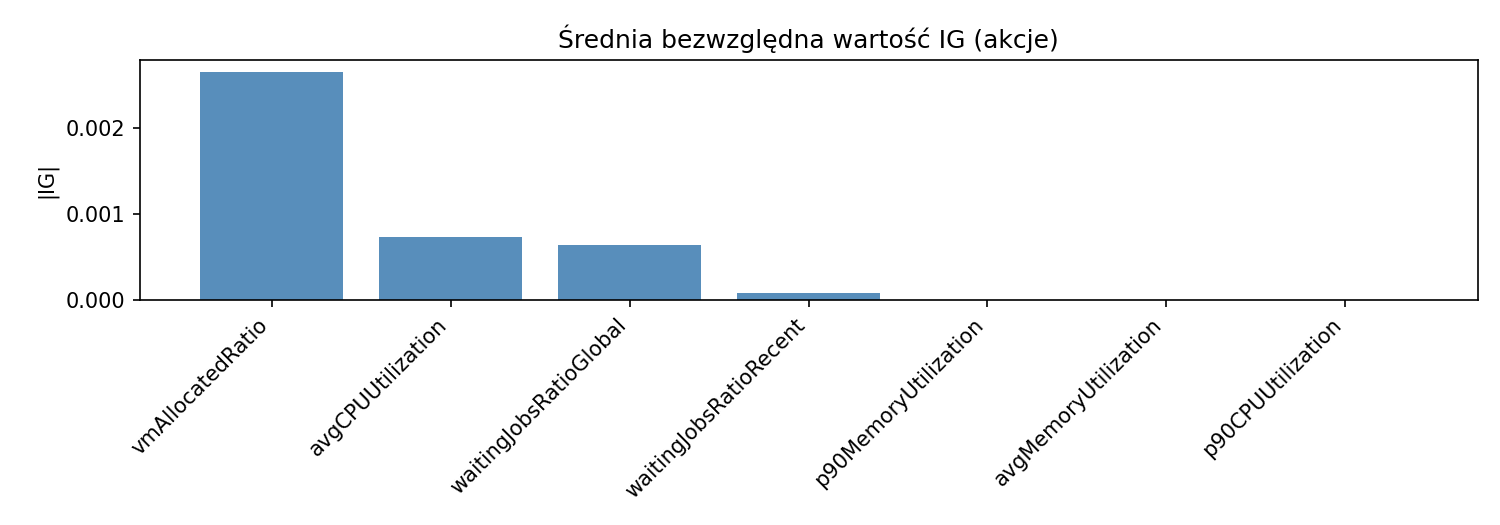

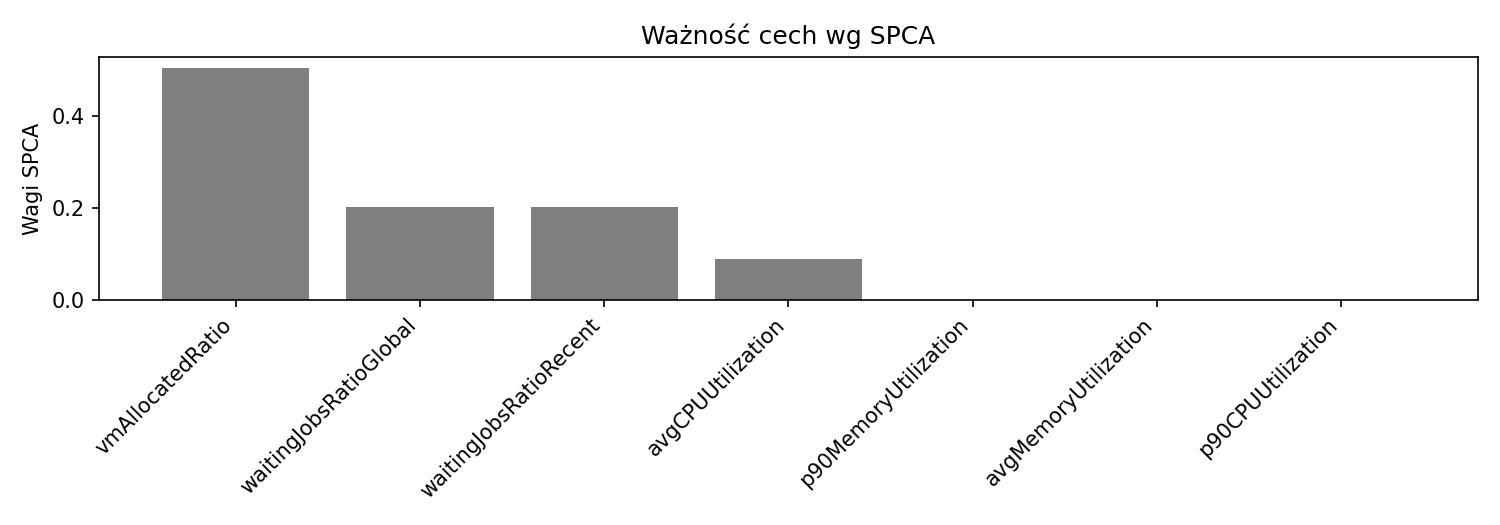

In [7]:
from pathlib import Path
from IPython.display import display, Image

folder = Path("runs/eval_spca_corr_ig")  # <-- change this
exts = {".png"}

for p in sorted(folder.iterdir()):
    if p.suffix.lower() in exts:
        display(Image(filename=str(p)))
